In [3]:
# !pip install machine_learning_datasets  --quiet
# !pip install tf_explain --quiet
# !pip install tf_keras_vis --quiet

#  Train Data, Test Data

In [4]:
import math
import os
import machine_learning_datasets as mldatasets
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import cv2
from tensorflow.keras.utils import get_file

#PART 1 only
from tf_explain.core.activations import ExtractActivations
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_explain.core.integrated_gradients import IntegratedGradients

In [5]:
# Load the dataset
X_train, X_test, X_val, X_val_orig, y_train, y_test, y_val, y_val_orig = mldatasets.load("fruits-360", prepare=True)

# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

# Update OneHotEncoder to use 'sparse_output' instead of 'sparse'
ohe = preprocessing.OneHotEncoder(sparse_output=False)  # Updated parameter
ohe.fit(y_train)

# Get the list of fruit labels
fruits_l = ohe.categories_[0].tolist()
print(fruits_l)


https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/fruits-360_abbrev.zip downloaded to d:\Everything\BTU Notes\Winter 23\Explainable ML\8\data\fruits-360_abbrev.zip
d:\Everything\BTU Notes\Winter 23\Explainable ML\8\data\fruits-360_abbrev.zip uncompressed to d:\Everything\BTU Notes\Winter 23\Explainable ML\8\data\fruits-360_abbrev
10633 dataset files found in d:\Everything\BTU Notes\Winter 23\Explainable ML\8\data\fruits-360_abbrev folder
['Apple Golden', 'Apple Granny Smith', 'Apple Red', 'Avocado', 'Banana', 'Clementine', 'Grapefruit Pink', 'Mango Red', 'Nectarine', 'Onion Red', 'Onion White', 'Orange', 'Peach', 'Pear', 'Pomegranate', 'Tomato']


In [6]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)
tf.random.set_seed(rand)

# Plot test and validation data

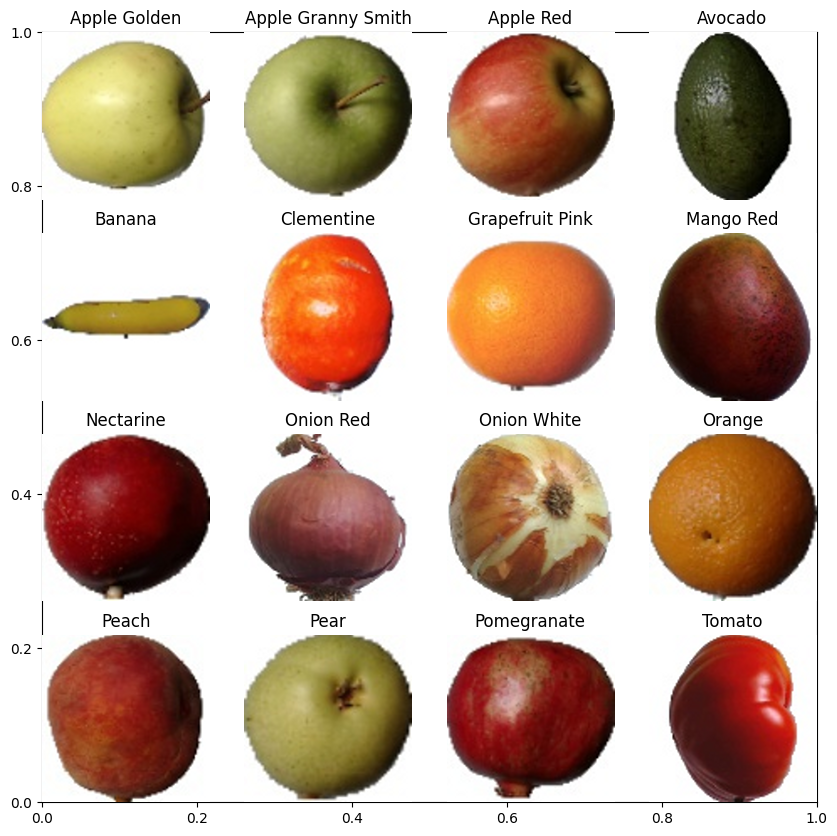

In [7]:
plt.subplots(figsize=(10,10))
for f, fruit in zip([*range(len(fruits_l))], fruits_l):
    plt.subplot(4, 4, f+1)
    plt.title(fruits_l[f], fontsize=12)
    idx = np.random.choice(np.where(y_test[:,0] == fruit)[0], 1)[0]
    plt.imshow(X_test[idx], interpolation='spline16')
    plt.axis("off")
plt.show()

# Plot Validation data 

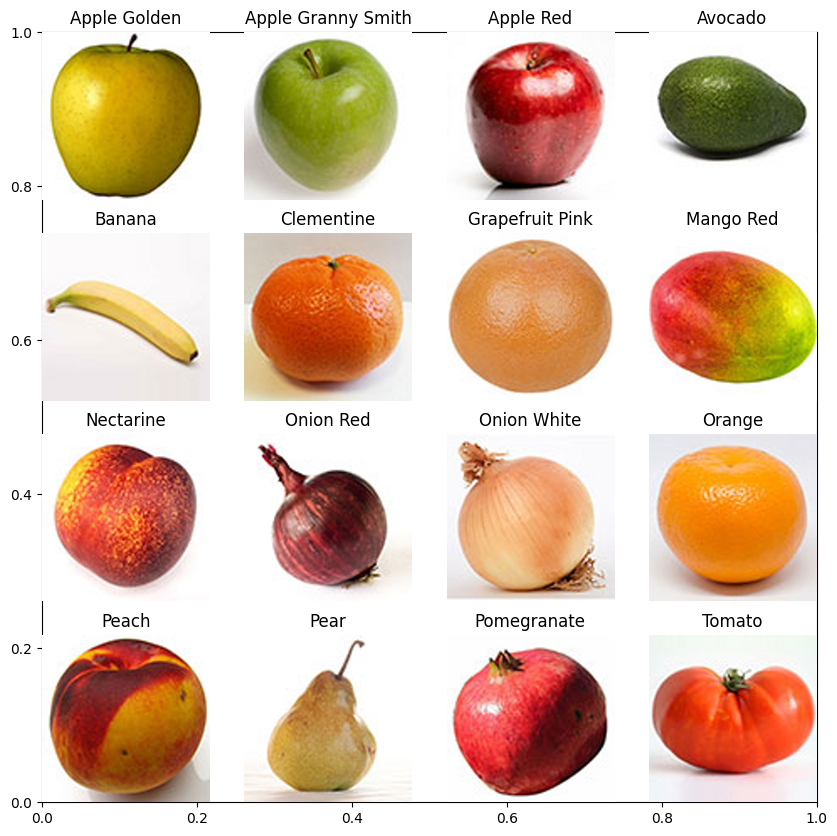

In [8]:
plt.subplots(figsize=(10,10))
for f, fruit in zip([*range(len(fruits_l))], fruits_l):
    plt.subplot(4, 4, f+1)
    plt.title(fruits_l[f], fontsize=12)
    idx = np.random.choice(np.where(y_val[:,0] == fruit)[0], 1)[0]
    plt.imshow(X_val[idx], interpolation='spline16')
    plt.axis("off")
plt.show()

# Load Model

In [9]:
model_path = get_file('CNN_fruits_final.hdf5',
            'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/CNN_fruits_final.hdf5?raw=true')
cnn_fruits_mdl = keras.models.load_model(model_path)
cnn_fruits_mdl.summary()

4267608/4267608 [==============================] - 0s 0us/step


Model: "CNN_fruits"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 99, 99, 16)        208       
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 49, 49, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        2080      
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 24, 24, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 64)        8256      
                                                                 
 maxpool2d_3 (MaxPooling2D)  (None, 11, 11, 64)        0         
                                                         

# Accuracy: training, test, validation

In [10]:
train_score = cnn_fruits_mdl.evaluate(X_train, ohe.transform(y_train),\
verbose=0)
test_score = cnn_fruits_mdl.evaluate(X_test, ohe.transform(y_test),\
verbose=0)
val_score = cnn_fruits_mdl.evaluate(X_val, ohe.transform(y_val),\
verbose=0)
print('Train accuracy:\t{:.1%}'.format(train_score[1]))
print('Test accuracy:\t{:.1%}'.format(test_score[1]))
print('Val accuracy:\t{:.1%}'.format(val_score[1]))


Train accuracy:	100.0%
Test accuracy:	99.9%
Val accuracy:	31.2%


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [12]:

# Load the model
model = keras.models.load_model(model_path)

new_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(32, (2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),
    
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')  # Adjust the number of units according to the number of classes
])



# Example: (filter_height, filter_width, input_channels, output_channels)
# Now you can set the custom filter weights as before
det = np.array([[[[0]], [[1]], [[0]]],
                [[[0]], [[1]], [[0]]],
                [[[0]], [[1]], [[0]]]], dtype='float32')
det_reshaped = np.repeat(det, 3, axis=2)
det_final = np.repeat(det_reshaped, 16, axis=3)
current_biases = np.zeros((16,))  # Assuming 16 filters
new_model.layers[0].set_weights([det_final, current_biases])



In [13]:


# Compile the model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
new_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 11, 11, 64)        

In [14]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [15]:
# Load the image file
img_path = "E:/Study/Explainable ML/Mensa.jpg"

# Load the image with a target size of (100, 100)
img = image.load_img(img_path, target_size=(100, 100))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to add the batch size as 1
img_tensor = np.expand_dims(img_array, axis=0)

# Normalize the image tensor by dividing by 255 (to scale the pixel values between 0 and 1)
img_tensor /= 255.

# Check the shape of the tensor
img_tensor.shape, img_tensor.dtype

FileNotFoundError: [Errno 2] No such file or directory: 'E:/Study/Explainable ML/Mensa.jpg'

1/1 [==============================] - 0s 152ms/step


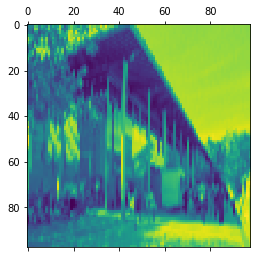

In [ ]:
# Create a new model that outputs the results after the first Conv2D layer
layer_outputs = [layer.output for layer in new_model.layers[:2]]  # Up to the first Conv2D and MaxPooling2D
activation_model = Model(inputs=new_model.input, outputs=layer_outputs)

# Get the output of the Conv2D layer
activations = activation_model.predict(img_tensor)

# Assuming you want to visualize the output of the first filter in the first Conv2D layer
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')  # Adjust the last index for other filters
plt.show()

In [ ]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

# Function to apply filters and plot images
def apply_filters_and_plot(img):
    # Apply filters
    smooth_img = img.filter(ImageFilter.SMOOTH)
    contour_img = img.filter(ImageFilter.CONTOUR)
    detail_img = img.filter(ImageFilter.DETAIL)
    sharpen_img = img.filter(ImageFilter.SHARPEN)
    emboss_img = img.filter(ImageFilter.EMBOSS)
    edge_enhance_img = img.filter(ImageFilter.EDGE_ENHANCE)

    # Plot the images with applied filters
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    ax = axes.ravel()

    ax[0].imshow(smooth_img)
    ax[0].set_title("Smoothed")
    ax[0].axis('off')

    ax[1].imshow(contour_img)
    ax[1].set_title("Contour")
    ax[1].axis('off')

    ax[2].imshow(detail_img)
    ax[2].set_title("Detail")
    ax[2].axis('off')

    ax[3].imshow(sharpen_img)
    ax[3].set_title("Sharpened")
    ax[3].axis('off')

    ax[4].imshow(emboss_img)
    ax[4].set_title("Embossed")
    ax[4].axis('off')
    
    ax[5].imshow(edge_enhance_img)
    ax[5].set_title("Edge Enhanced")
    ax[5].axis('off')

    # Display the figure with the subplots
    plt.tight_layout()
    plt.show()

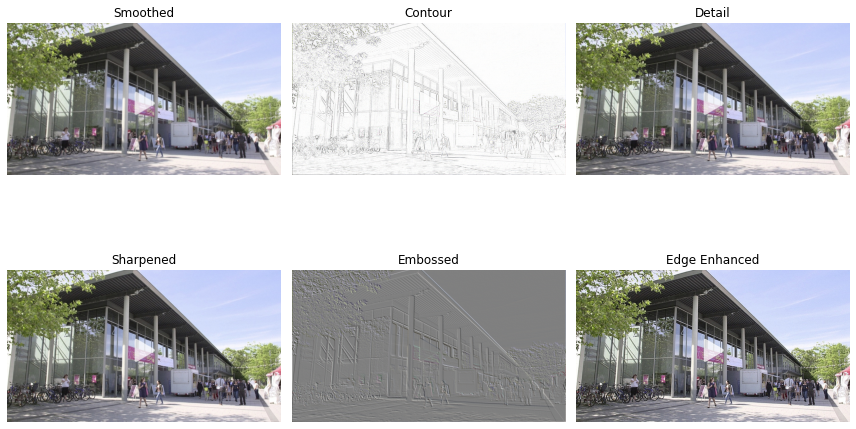

In [ ]:
img = Image.open(img_path)


apply_filters_and_plot(img)

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array



In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
'dog', 'frog', 'horse', 'ship', 'truck']

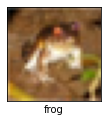

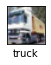

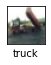

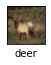

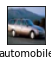

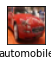

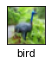

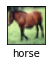

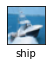

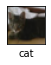

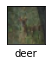

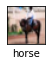

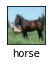

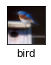

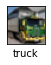

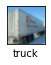

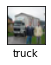

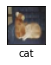

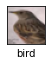

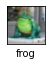

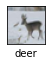

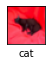

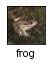

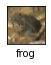

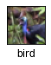

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
    plt.show()

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(32, 32,
3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.summary()
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=
True),
metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=8,
validation_data=(test_images, test_labels))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 4)         112       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 4)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 16)        592       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
Total params: 5,344
Trainable params: 5,344
Non-traina

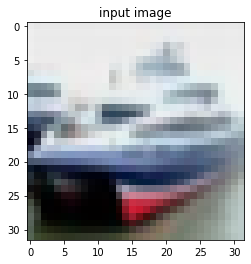

ship_arr.shape
 (32, 32, 3)


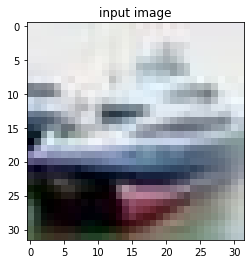

In [ ]:
img = test_images[1]
plt.title("input image")
plt.imshow(img)
plt.show()
img_in = img_to_array(img)
img_in = img_in.reshape((1,) + img_in.shape)
img_in /= 255.0 # model input
img1 = img*255
img = Image.fromarray(img1.astype('uint8'), 'RGB')
img.save("./Data/img1.jpg")
image = Image.open("./Data/img1.jpg")
ship_arr = np.array(image)
print("ship_arr.shape\n",ship_arr.shape)
plt.title("input image")
plt.imshow(ship_arr)
plt.show()

In [ ]:
layer_names = [layer.name for layer in model.layers]
print("layer_names\n",layer_names)
layer_outputs = [layer.output for layer in model.layers]
print("layer_outputs\n",layer_outputs )

layer_names
 ['conv2d_4', 'max_pooling2d_4', 'conv2d_5', 'max_pooling2d_5', 'conv2d_6', 'flatten_1', 'dense_2', 'dense_3']
layer_outputs
 [<KerasTensor: shape=(None, 30, 30, 4) dtype=float32 (created by layer 'conv2d_4')>, <KerasTensor: shape=(None, 15, 15, 4) dtype=float32 (created by layer 'max_pooling2d_4')>, <KerasTensor: shape=(None, 13, 13, 16) dtype=float32 (created by layer 'conv2d_5')>, <KerasTensor: shape=(None, 6, 6, 16) dtype=float32 (created by layer 'max_pooling2d_5')>, <KerasTensor: shape=(None, 4, 4, 32) dtype=float32 (created by layer 'conv2d_6')>, <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'flatten_1')>, <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_2')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>]


In [ ]:
feature_map_model = Model(inputs=model.input, outputs=layer_outputs)
feature_maps = feature_map_model.predict(img_in)

1/1 [==============================] - 0s 141ms/step


In [ ]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the conv2d_4 is =======>> (1, 30, 30, 4)
The shape of the max_pooling2d_4 is =======>> (1, 15, 15, 4)
The shape of the conv2d_5 is =======>> (1, 13, 13, 16)
The shape of the max_pooling2d_5 is =======>> (1, 6, 6, 16)
The shape of the conv2d_6 is =======>> (1, 4, 4, 32)
The shape of the flatten_1 is =======>> (1, 512)
The shape of the dense_2 is =======>> (1, 64)
The shape of the dense_3 is =======>> (1, 10)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

C:\Users\vinay\AppData\Local\Temp\ipykernel_42280\2098597893.py:11: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
C:\Users\vinay\AppData\Local\Temp\ipykernel_42280\2098597893.py:14: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


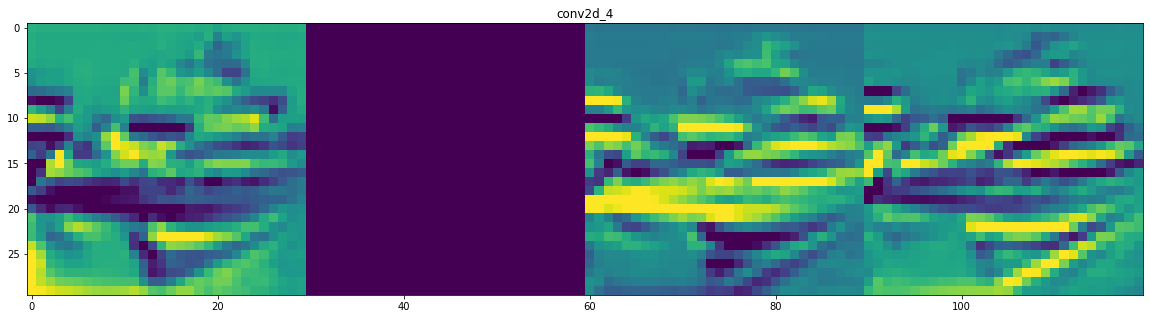

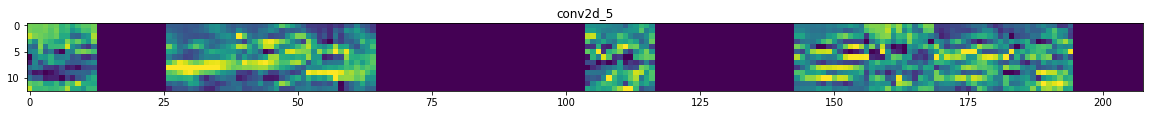

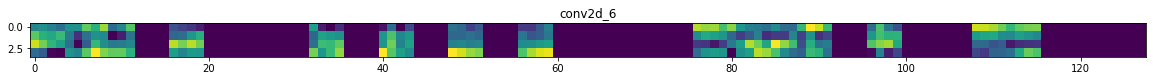

In [ ]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    if 'conv' in layer_name:
        size = feature_map.shape[ 1] # feature map shape (1, size, size, n_features)
        n_features = feature_map.shape[-1] # number of filters in the feature map
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        # process the feature to be visually (for all filters)
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # Tile each filter into a horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x# Display the grid
        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' )

#  second convolutional layer with 64 3x3 filters

In [ ]:
# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding the new convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

# Changing the last dense layer
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10))  # Assuming 10 classes for classification

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 4)         112       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 4)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 16)        592       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 32)          4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 2, 64)         

In [ ]:
# Assuming train_images, train_labels, test_images, test_labels are defined
# history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Accessing layers and outputs for visualization (assuming the model is trained)
layer_names = [layer.name for layer in model.layers]
print("layer_names\n", layer_names)
layer_outputs = [layer.output for layer in model.layers]
print("layer_outputs\n", layer_outputs)

# Assuming img_in is defined and preprocessed
# feature_map_model = Model(inputs=model.input, outputs=layer_outputs)
# feature_maps = feature_map_model.predict(img_in)


layer_names
 ['conv2d_10', 'max_pooling2d_8', 'conv2d_11', 'max_pooling2d_9', 'conv2d_12', 'conv2d_13', 'flatten_3', 'dense_6', 'dense_7', 'dense_8']
layer_outputs
 [<KerasTensor: shape=(None, 30, 30, 4) dtype=float32 (created by layer 'conv2d_10')>, <KerasTensor: shape=(None, 15, 15, 4) dtype=float32 (created by layer 'max_pooling2d_8')>, <KerasTensor: shape=(None, 13, 13, 16) dtype=float32 (created by layer 'conv2d_11')>, <KerasTensor: shape=(None, 6, 6, 16) dtype=float32 (created by layer 'max_pooling2d_9')>, <KerasTensor: shape=(None, 4, 4, 32) dtype=float32 (created by layer 'conv2d_12')>, <KerasTensor: shape=(None, 2, 2, 64) dtype=float32 (created by layer 'conv2d_13')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'flatten_3')>, <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_6')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense_7')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_8')>]


In [ ]:
# Assuming test_images is defined and preprocessed
test_image = test_images[3:4]  # Selecting the 4th image from test_images

# Perform the prediction
prediction = model.predict(test_image)

# Process and display the prediction
predicted_class = np.argmax(prediction, axis=1)
print("Predicted class for test_images[3]:", class_names[int(predicted_class)])

print("Actual class name:", class_names[4])

1/1 [==============================] - 0s 142ms/step
Predicted class for test_images[3]: automobile
Actual class name: deer


C:\Users\vinay\AppData\Local\Temp\ipykernel_42280\3658276136.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted class for test_images[3]:", class_names[int(predicted_class)])


In [ ]:
!pip install opencv-python matplotlib --quiet


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



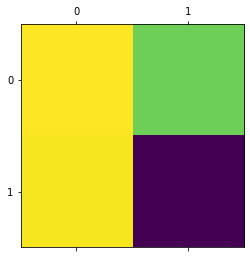

In [ ]:

# test_image = test_images[3:4]  # Example

# Generate the heatmap

last_conv_layer_name = 'conv2d_13'  # Replace with the actual last conv layer name
heatmap = make_gradcam_heatmap(test_image, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# If you want to superimpose the heatmap on the original image:
img = test_images[3]  # This should be the raw image, not preprocessed
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imshow('Grad-CAM', superimposed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


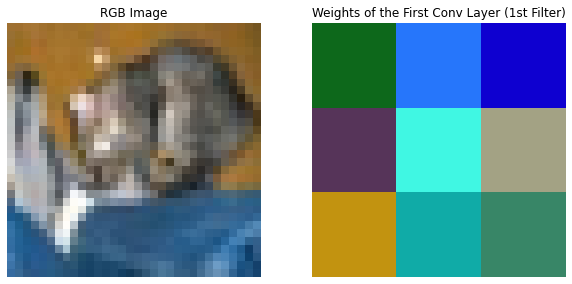

In [ ]:
# Retrieve weights from the first convolutional layer
# Note: The name of the first conv layer might differ. Adjust the index [0] if necessary.
first_conv_layer = model.layers[0]
weights, biases = first_conv_layer.get_weights()

# Normalize the weights
weights_min = weights.min()
weights_max = weights.max()
weights = (weights - weights_min) / (weights_max - weights_min)

# Plot the RGB image
plt.figure(figsize=(10, 5))

# Assuming the first image in `test_images` is RGB and has the shape (32, 32, 3)
plt.subplot(1, 2, 1)
plt.imshow(test_images[0])
plt.title('RGB Image')
plt.axis('off')

# Plot the weights of the first convolutional layer
# Note: There might be multiple filters and each has a weight matrix.
# We will plot the weights for the first filter as an example.

# Assuming the first filter and its first channel (for RGB, hence 3 channels)
plt.subplot(1, 2, 2)
plt.imshow(weights[:, :, :, 0])  # Change the last index if you want to plot a different filter
plt.title('Weights of the First Conv Layer (1st Filter)')
plt.axis('off')

plt.show()